# Градиентные методы оптимизации
параметрических моделей машинного обучения

## Метод стохастического градиентного спуска

In [1]:
import plotly.graph_objects as go
import plotly.express as px

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
from tqdm import tqdm

In [5]:
from linear_regression_model import linear_regression
from data_generator import *
from sample_bootstrap import *
from rmse import *
from estimate_parameters_range import *

Генерируем синтетическую задачу и посмотрим на данные

In [6]:
X,y,X_test,y_test = generate_data(cov_matrix=corr_coeff_2_cov_matr(corr_coeff=0.3), epsilon_var=0.2)

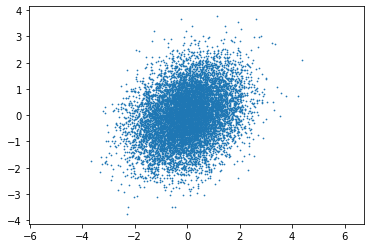

In [7]:
plt.scatter(X[:,0], X[:,1], s=0.5)
_ = plt.axis('equal')

ВНИМАНИЕ!<br />
Не забыть, что точками здесь отображены данные в пространстве признаков $x^{(0)}, x^{(1)}$ <br />
**Целевая переменная здесь не отображена!**

In [10]:
y.shape

(10000, 1)

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=X[:,0],
                                   y=X[:,1],
                                   z=y[:,0],
                                   mode='markers',
                                   marker=dict(size=1))
                     ])
fig.update_layout(autosize=False,
                  width=800,
                  height=800,
                  margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
                  scene = dict(xaxis_title='x0',
                               yaxis_title='x1',
                               zaxis_title='y'))
fig.show()

In [13]:
# theta_values_curr_sample_size, t1_linspace, t2_linspace, t0_means = estimate_parameters_range(X, y)
theta_means, theta_min, theta_max = estimate_parameters_range(X, y)
theta_range = theta_max-theta_min

In [14]:
theta_means.shape

(3, 1)

In [15]:
theta_range.shape

(3, 1)

In [17]:
t1y0_linspace = np.linspace(theta_means[1,0]-10*theta_range[1,0], theta_means[1,0]+10*theta_range[1,0], 200)
t2y0_linspace = np.linspace(theta_means[2,0]-10*theta_range[2,0], theta_means[2,0]+10*theta_range[2,0], 200)
# t1y1_linspace = np.linspace(theta_means[1,1]-10*theta_range[1,1], theta_means[1,1]+10*theta_range[1,1], 200)
# t2y1_linspace = np.linspace(theta_means[2,1]-10*theta_range[2,1], theta_means[2,1]+10*theta_range[2,1], 200)

In [52]:
t1y0_mesh,t2y0_mesh = np.meshgrid(t1y0_linspace, t2y0_linspace)
t0y0_mesh = np.ones_like(t1y0_mesh) * theta_means[0,0]
# t0y1_mesh = np.ones_like(t1y0_mesh) * theta_means[0,1]
# t1y1_mesh = np.ones_like(t1y0_mesh) * theta_means[1,1]
# t2y1_mesh = np.ones_like(t1y0_mesh) * theta_means[2,1]

In [53]:
t1y0_mesh.shape

(200, 200)

In [63]:
# theta_space = np.concatenate([[t0y0_mesh[np.newaxis,:,:], t1y0_mesh[np.newaxis,:,:], t2y0_mesh[np.newaxis,:,:]],
#                               [t0y1_mesh[np.newaxis,:,:], t1y1_mesh[np.newaxis,:,:], t2y1_mesh[np.newaxis,:,:]]], axis=1)
theta_space = np.concatenate([[t0y0_mesh[np.newaxis,:,:], t1y0_mesh[np.newaxis,:,:], t2y0_mesh[np.newaxis,:,:]]], axis=1)

In [67]:
loss_values = np.zeros_like(t1y0_mesh)
for i,j in itertools.product(np.arange(t1y0_linspace.shape[0]), np.arange(t2y0_linspace.shape[0])):
    curr_theta = theta_space[:,:,i,j]
    loss_values[i,j] = loss(X_test, y_test, curr_theta)

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x = t1y0_mesh.ravel(),
                                   y = t2y0_mesh.ravel(),
                                   z = loss_values.ravel(),
                                   mode='markers',
                                   marker=dict(size=5,
                                               color=loss_values.ravel(),
                                               colorscale='jet',
                                               showscale=True,
                                               opacity=0.8))
                     ])
fig.update_layout(autosize=False,
                  width=800,
                  height=800,
                  margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
                  yaxis = dict(scaleanchor = "x",
                               scaleratio = 1),
                  scene = dict(aspectmode='cube',
                               xaxis = dict(title='x1'),
                               yaxis = dict(title='x2'),
                               zaxis = dict(title='loss')))
# fig.show()

Ну да, целевая переменная уже состоит из двух значений.

- ВОПРОС
Если по обоим этим значениям функция ошибки - MSE, есть ли разница, сколько целевых переменных?<br />
Все равно функция ошибки суммирует/осредняет как по объектам выборки, так и по целевым переменным.

На самом деле разница есть. Представьте, что целевые переменные $y^{(0)}$ и $y{(1)}$ различаются на 3-4 порядка. Что будет с градиентами функции ошибки по соответствующим параметрам? Будут ли они единого масштаба? Если нет - то насколько они будут различаться?

подсказка: см. выражение для градиента функции ошибки ниже.

## Решение задачи линейной регрессии методом градиентной оптимизации
Представим, что данных так много, что они не помещаются в память (готовимся к **"большим климатическим/геологическим данным"**)

### Вспомним выражение для градиента функции ошибки:
Все еще работаем с квадратичной функцией ошибки, предполагая, что шум в данных распределен нормально, и что его дисперсия не зависит от данных.

#### <u>Определения</u>

Признаковое описание одного объекта

$$
x_i = (x_{i}^{(0)}, x_{i}^{(1)}, \dots, x_{i}^{(n)})
$$

Матрица коэффициентов линейной регрессии (размером ${n}\times{m}$):

$$
\theta = 
\begin{bmatrix}
\theta_{0}^{(0)} & \theta_{0}^{(1)} & \dots & \theta_{0}^{(m)} \\
\theta_{1}^{(0)} & \theta_{1}^{(1)} & \dots & \theta_{1}^{(m)} \\
\dots \\
\theta_{n}^{(0)} & \theta_{n}^{(1)} & \dots & \theta_{n}^{(m)}
\end{bmatrix}
$$

Задача оптимизации выглядит следующим образом:

$$
\theta^* = \underset{\Theta}{\mathrm{argmin}} \sum_{j=1}^{m}\sum_{i=1}^{N}{\left( y^{(j)}_i-\theta_j\cdot x_i \right)^2}
$$

Матрица объекты-признаки (размером ${N}\times{n}$):

$$
X = \begin{bmatrix}
x_{0}^{(0)} & x_{0}^{(1)} & \dots & x_{0}^{(n)} \\
x_{1}^{(0)} & x_{1}^{(1)} & \dots & x_{1}^{(n)} \\
\dots \\
x_{N}^{(0)} & x_{N}^{(1)} & \dots & x_{N}^{(n)}
\end{bmatrix}
$$

Матрица целевых переменных (размером ${N}\times{m}$):

$$
Y = \begin{bmatrix}
y_{0}^{(0)} & y_{0}^{(1)} & \dots & x_{0}^{(m)} \\
y_{1}^{(0)} & y_{1}^{(1)} & \dots & x_{1}^{(m)} \\
\dots \\
y_{N}^{(0)} & y_{N}^{(1)} & \dots & x_{N}^{(m)}
\end{bmatrix}
$$

Функция ошибки:

$$
\mathscr{L}(\theta, X, Y) = \left(Y-X\cdot\theta\right)^T\cdot(Y-X\cdot\theta) = \\
{Y^T}{Y}-2\theta^T{X^T}{Y}+\theta^T{X^T}{X}{\theta}
$$

Для решения численной оптимизацией потребуется градиент функции ошибки в отношении $\theta$:

$$
\frac{\partial{\mathscr{L}(\theta, X, Y)}}{\partial{\theta}} = -2{X^T}{Y} + 2{X^T}X\theta
$$

### Вопросы на обсуждение
1. Что будет, если какие-то признаки (например, $x^{(1)}_{\dots}$) сильно отличаются по порядку величины от других (например, $x^{(2)}_{\dots}$). Пусть при этом целевые переменные $y^{(0)}_{\dots}$ и $y^{(1)}_{\dots}$ не слишком сильно отличаются по порядку.


2. Что будет, если целевые переменные $y^{(0)}_{\dots}$ и $y^{(1)}_{\dots}$ сильно отличаются по порядку величин? Пусть при этом признаки не слишком сильно отличаются по порядку.

### Выводы?

## Метод стохастического градиентного спуска.

In [70]:
def loss_grad(X,y,curr_theta):
    assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
    assert (y.ndim == 2), "y should be 2-dimensional: (N of objects, one column)"
    
    X_0 = np.ones((X.shape[0], 1), dtype=np.float)
    X_matrix = np.concatenate([X_0, X], axis=1)
#     y_column = y
    
    m1 = np.dot(X_matrix.T, y)
    m2 = np.dot(np.dot(X_matrix.T, X_matrix), curr_theta)
    grad = -2*m1 + 2*m2
    grad = grad/X.shape[0]
    return grad

Представим, что вся выборка ну никак не влезает в память.

Насколько точно можно оценить градиент функции ошибки, если использовать только часть выборки?

In [71]:
Xtrain,ytrain = X,y

In [72]:
theta0 = np.random.randn(X.shape[1]+1, 1)*0.2 + np.array(theta_means)
theta_grad_trainset = loss_grad(Xtrain, ytrain, theta0)
theta_grad_trainset

array([[ 0.15772885],
       [-0.35890607],
       [-0.00498679]])

In [73]:
sample_size_for_grad_estimation = int(Xtrain.shape[0]/2)
sample_size_for_grad_estimation

5000

In [74]:
theta_1y0_grads = []
theta_2y0_grads = []

for i in range(1000):
    subset_indices = np.random.permutation(Xtrain.shape[0])[:sample_size_for_grad_estimation]
    subset_X = Xtrain[subset_indices]
    subset_y = ytrain[subset_indices]
    grad_curr = loss_grad(subset_X, subset_y, theta0)
    theta_1y0_grads.append(grad_curr[1,0])
    theta_2y0_grads.append(grad_curr[2,0])

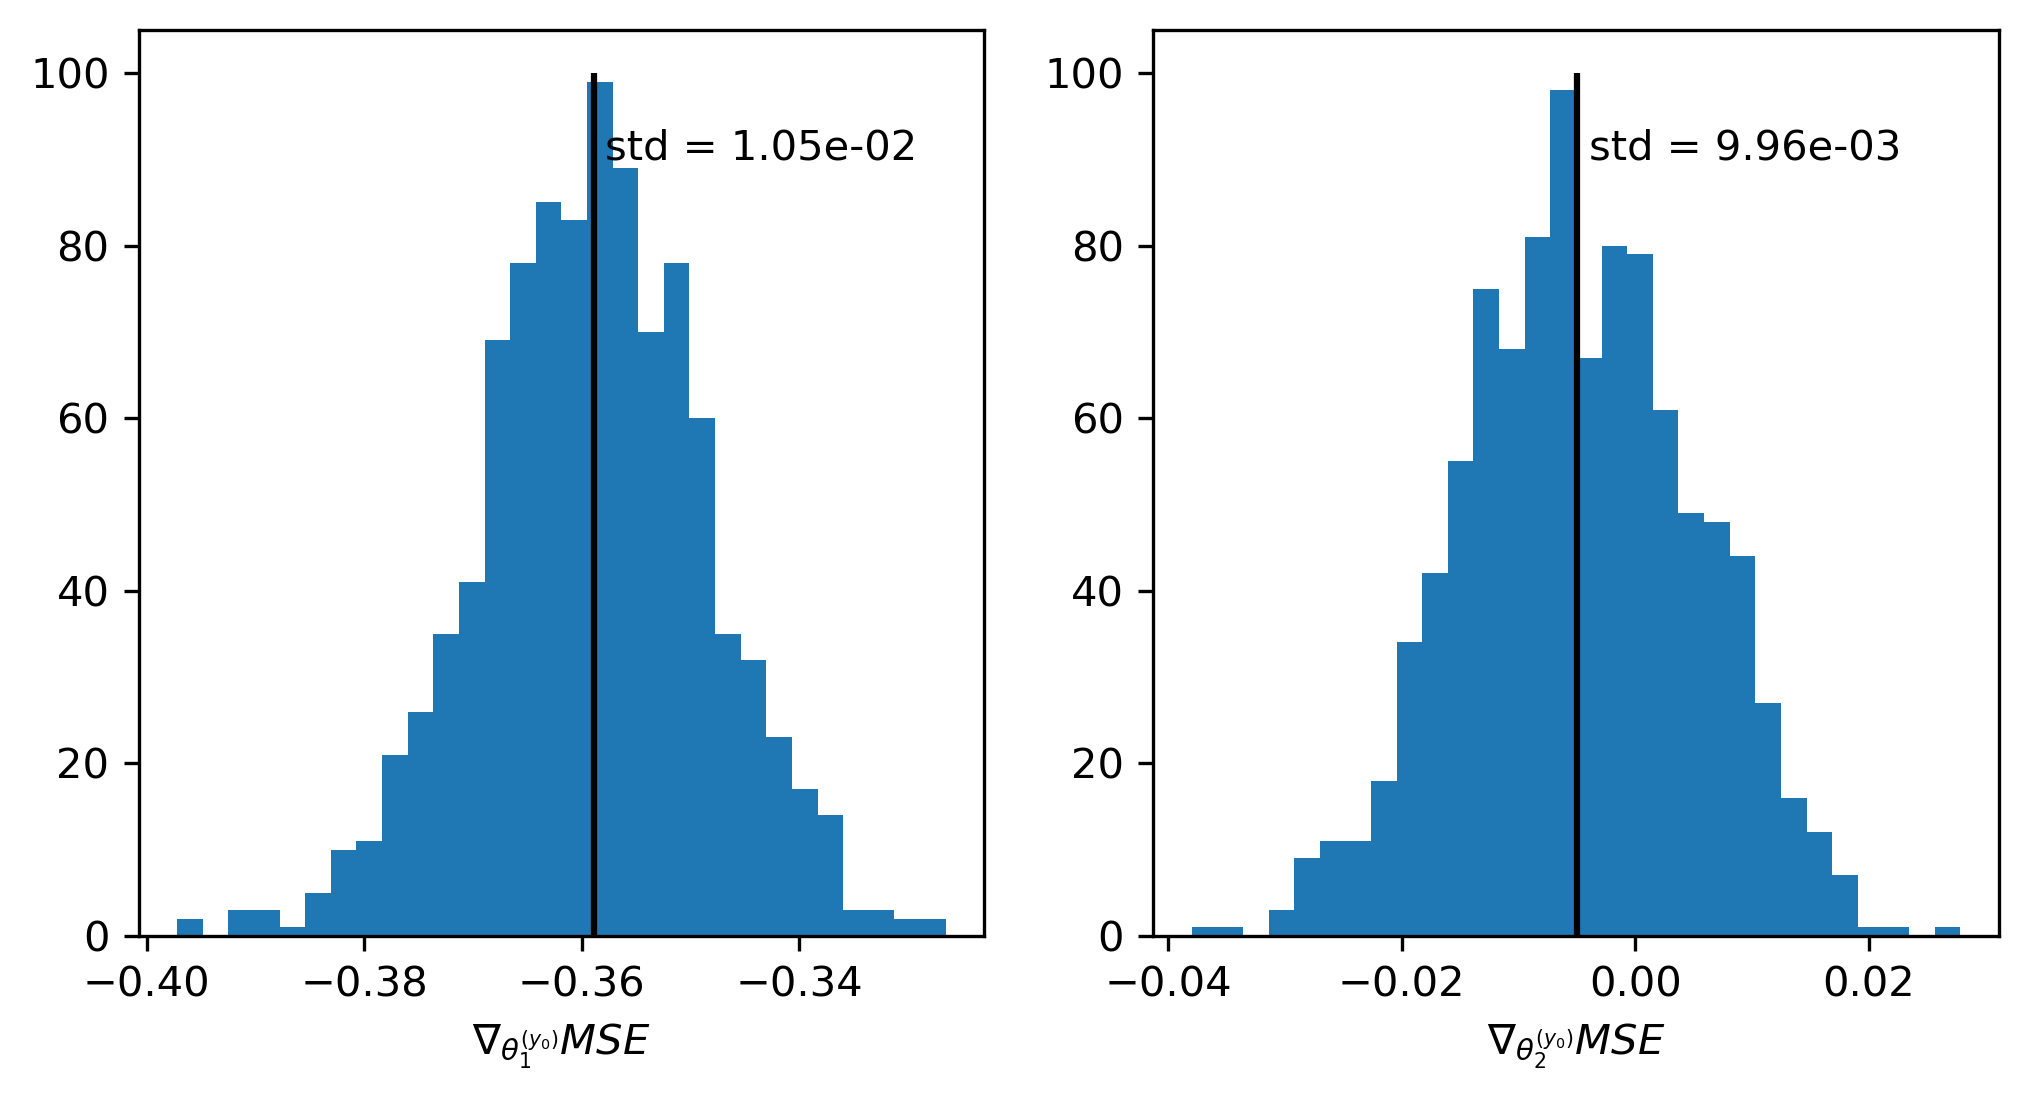

In [75]:
f = plt.figure(figsize=(8,4), dpi=300)

_ = plt.subplot(1,2,1)
_ = plt.hist(theta_1y0_grads, bins=30)
_ = plt.text(theta_grad_trainset[1,0] + 0.1*np.std(theta_1y0_grads), 90,
             'std = %.2e' % np.std(theta_1y0_grads))
_ = plt.vlines(theta_grad_trainset[1,0], 0, 100, 'black')
_ = plt.xlabel('$\\nabla_{\\theta_{1}^{(y_0)}}MSE$')

_ = plt.subplot(1,2,2)
_ = plt.hist(theta_2y0_grads, bins=30)
_ = plt.text(theta_grad_trainset[2,0] + 0.1*np.std(theta_2y0_grads), 90,
             'std = %.2e' % np.std(theta_2y0_grads))
_ = plt.vlines(theta_grad_trainset[2,0], 0, 100, 'black')
_ = plt.xlabel('$\\nabla_{\\theta_{2}^{(y_0)}}MSE$')

In [76]:
sample_size_for_grad_estimation = int(Xtrain.shape[0]/4)
sample_size_for_grad_estimation

2500

In [77]:
theta_1y0_grads = []
theta_2y0_grads = []

for i in range(1000):
    subset_indices = np.random.permutation(Xtrain.shape[0])[:sample_size_for_grad_estimation]
    subset_X = Xtrain[subset_indices]
    subset_y = ytrain[subset_indices]
    grad_curr = loss_grad(subset_X, subset_y, theta0)
    theta_1y0_grads.append(grad_curr[1,0])
    theta_2y0_grads.append(grad_curr[2,0])

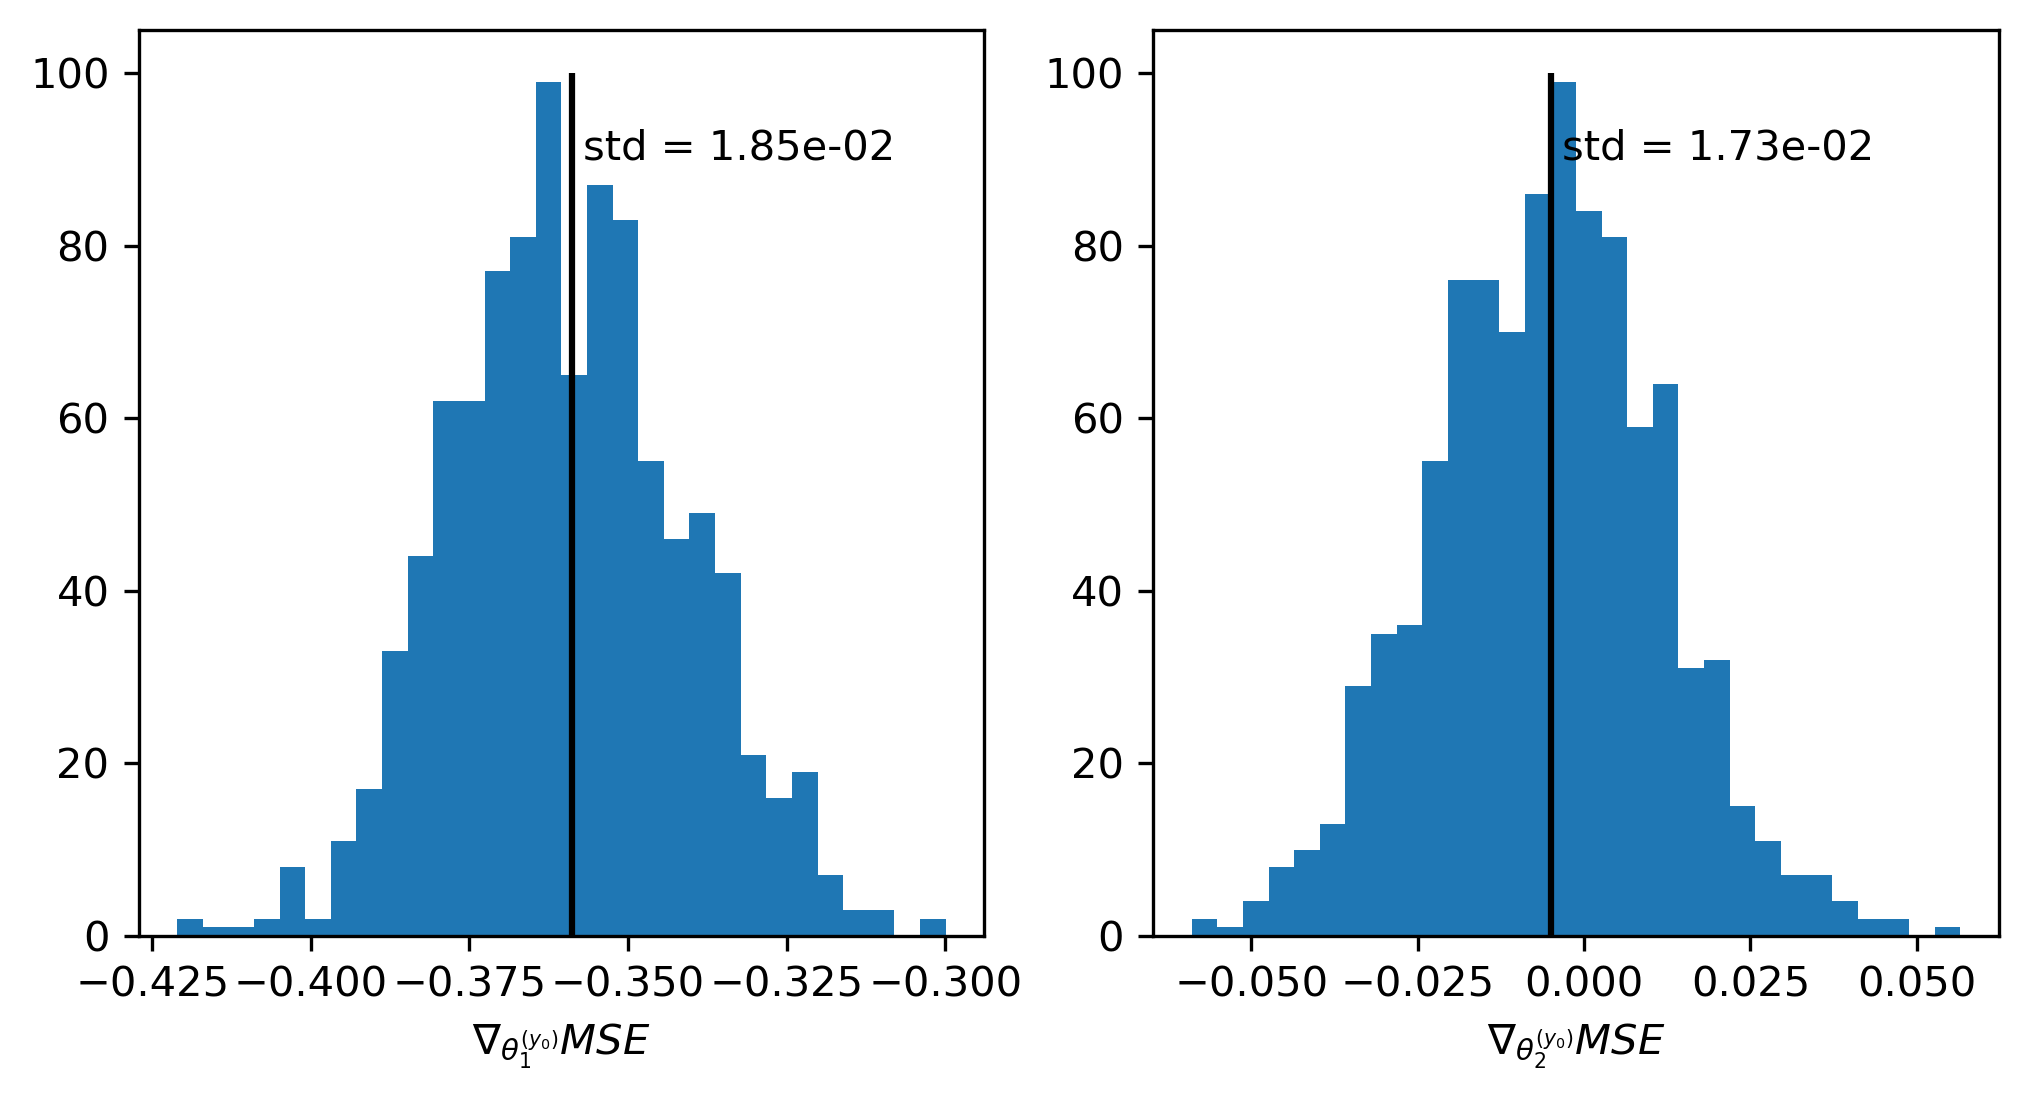

In [78]:
f = plt.figure(figsize=(8,4), dpi=300)

_ = plt.subplot(1,2,1)
_ = plt.hist(theta_1y0_grads, bins=30)
_ = plt.text(theta_grad_trainset[1,0] + 0.1*np.std(theta_1y0_grads), 90,
             'std = %.2e' % np.std(theta_1y0_grads))
_ = plt.vlines(theta_grad_trainset[1,0], 0, 100, 'black')
_ = plt.xlabel('$\\nabla_{\\theta_{1}^{(y_0)}}MSE$')

_ = plt.subplot(1,2,2)
_ = plt.hist(theta_2y0_grads, bins=30)
_ = plt.text(theta_grad_trainset[2,0] + 0.1*np.std(theta_2y0_grads), 90,
             'std = %.2e' % np.std(theta_2y0_grads))
_ = plt.vlines(theta_grad_trainset[2,0], 0, 100, 'black')
_ = plt.xlabel('$\\nabla_{\\theta_{2}^{(y_0)}}MSE$')

In [79]:
sample_size_for_grad_estimation = int(Xtrain.shape[0]/8)
sample_size_for_grad_estimation

1250

In [80]:
theta_1y0_grads = []
theta_2y0_grads = []

for i in range(1000):
    subset_indices = np.random.permutation(Xtrain.shape[0])[:sample_size_for_grad_estimation]
    subset_X = Xtrain[subset_indices]
    subset_y = ytrain[subset_indices]
    grad_curr = loss_grad(subset_X, subset_y, theta0)
    theta_1y0_grads.append(grad_curr[1,0])
    theta_2y0_grads.append(grad_curr[2,0])

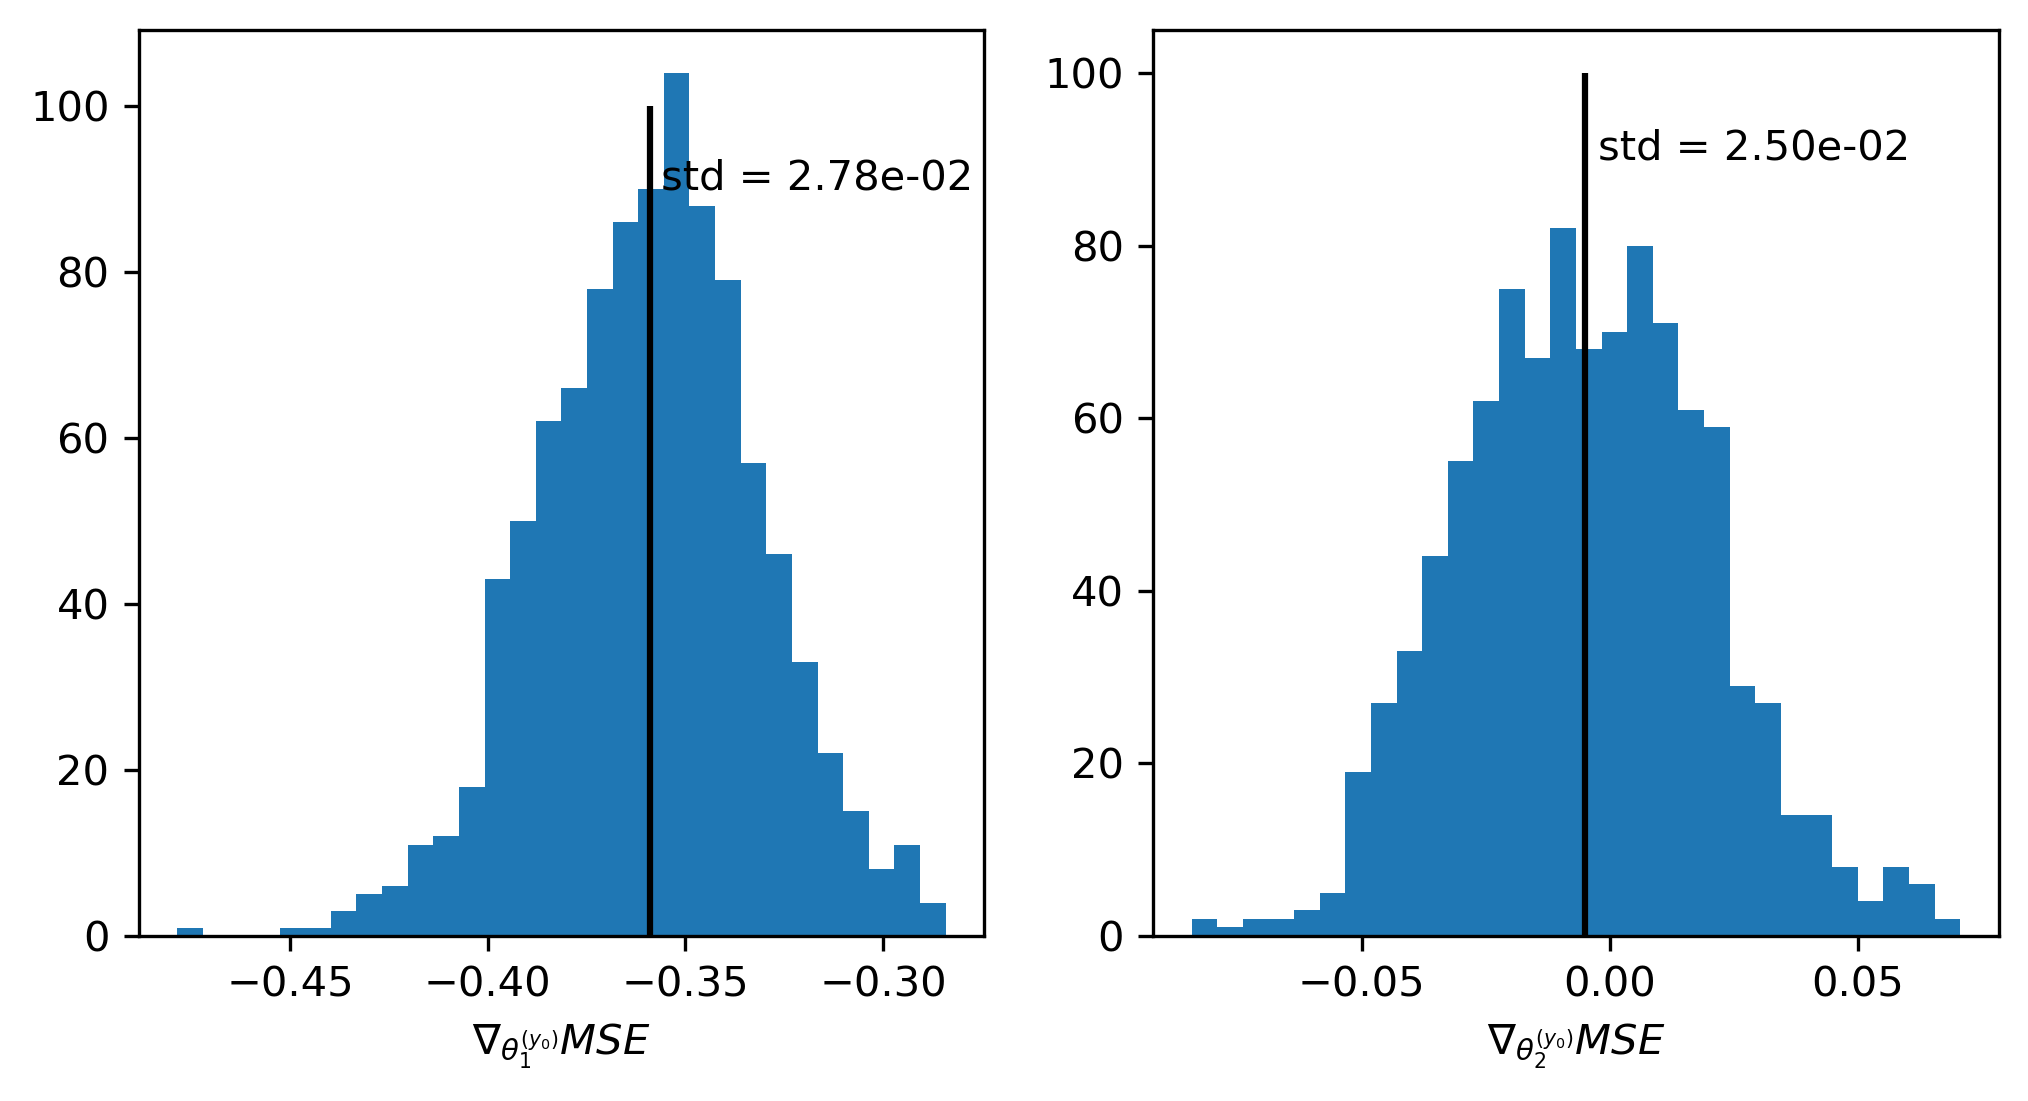

In [81]:
f = plt.figure(figsize=(8,4), dpi=300)

_ = plt.subplot(1,2,1)
_ = plt.hist(theta_1y0_grads, bins=30)
_ = plt.text(theta_grad_trainset[1,0] + 0.1*np.std(theta_1y0_grads), 90,
             'std = %.2e' % np.std(theta_1y0_grads))
_ = plt.vlines(theta_grad_trainset[1,0], 0, 100, 'black')
_ = plt.xlabel('$\\nabla_{\\theta_{1}^{(y_0)}}MSE$')

_ = plt.subplot(1,2,2)
_ = plt.hist(theta_2y0_grads, bins=30)
_ = plt.text(theta_grad_trainset[2,0] + 0.1*np.std(theta_2y0_grads), 90,
             'std = %.2e' % np.std(theta_2y0_grads))
_ = plt.vlines(theta_grad_trainset[2,0], 0, 100, 'black')
_ = plt.xlabel('$\\nabla_{\\theta_{2}^{(y_0)}}MSE$')

In [82]:
sample_size_for_grad_estimation = int(Xtrain.shape[0]/16)
sample_size_for_grad_estimation

625

In [83]:
theta_1y0_grads = []
theta_2y0_grads = []

for i in range(1000):
    subset_indices = np.random.permutation(Xtrain.shape[0])[:sample_size_for_grad_estimation]
    subset_X = Xtrain[subset_indices]
    subset_y = ytrain[subset_indices]
    grad_curr = loss_grad(subset_X, subset_y, theta0)
    theta_1y0_grads.append(grad_curr[1,0])
    theta_2y0_grads.append(grad_curr[2,0])

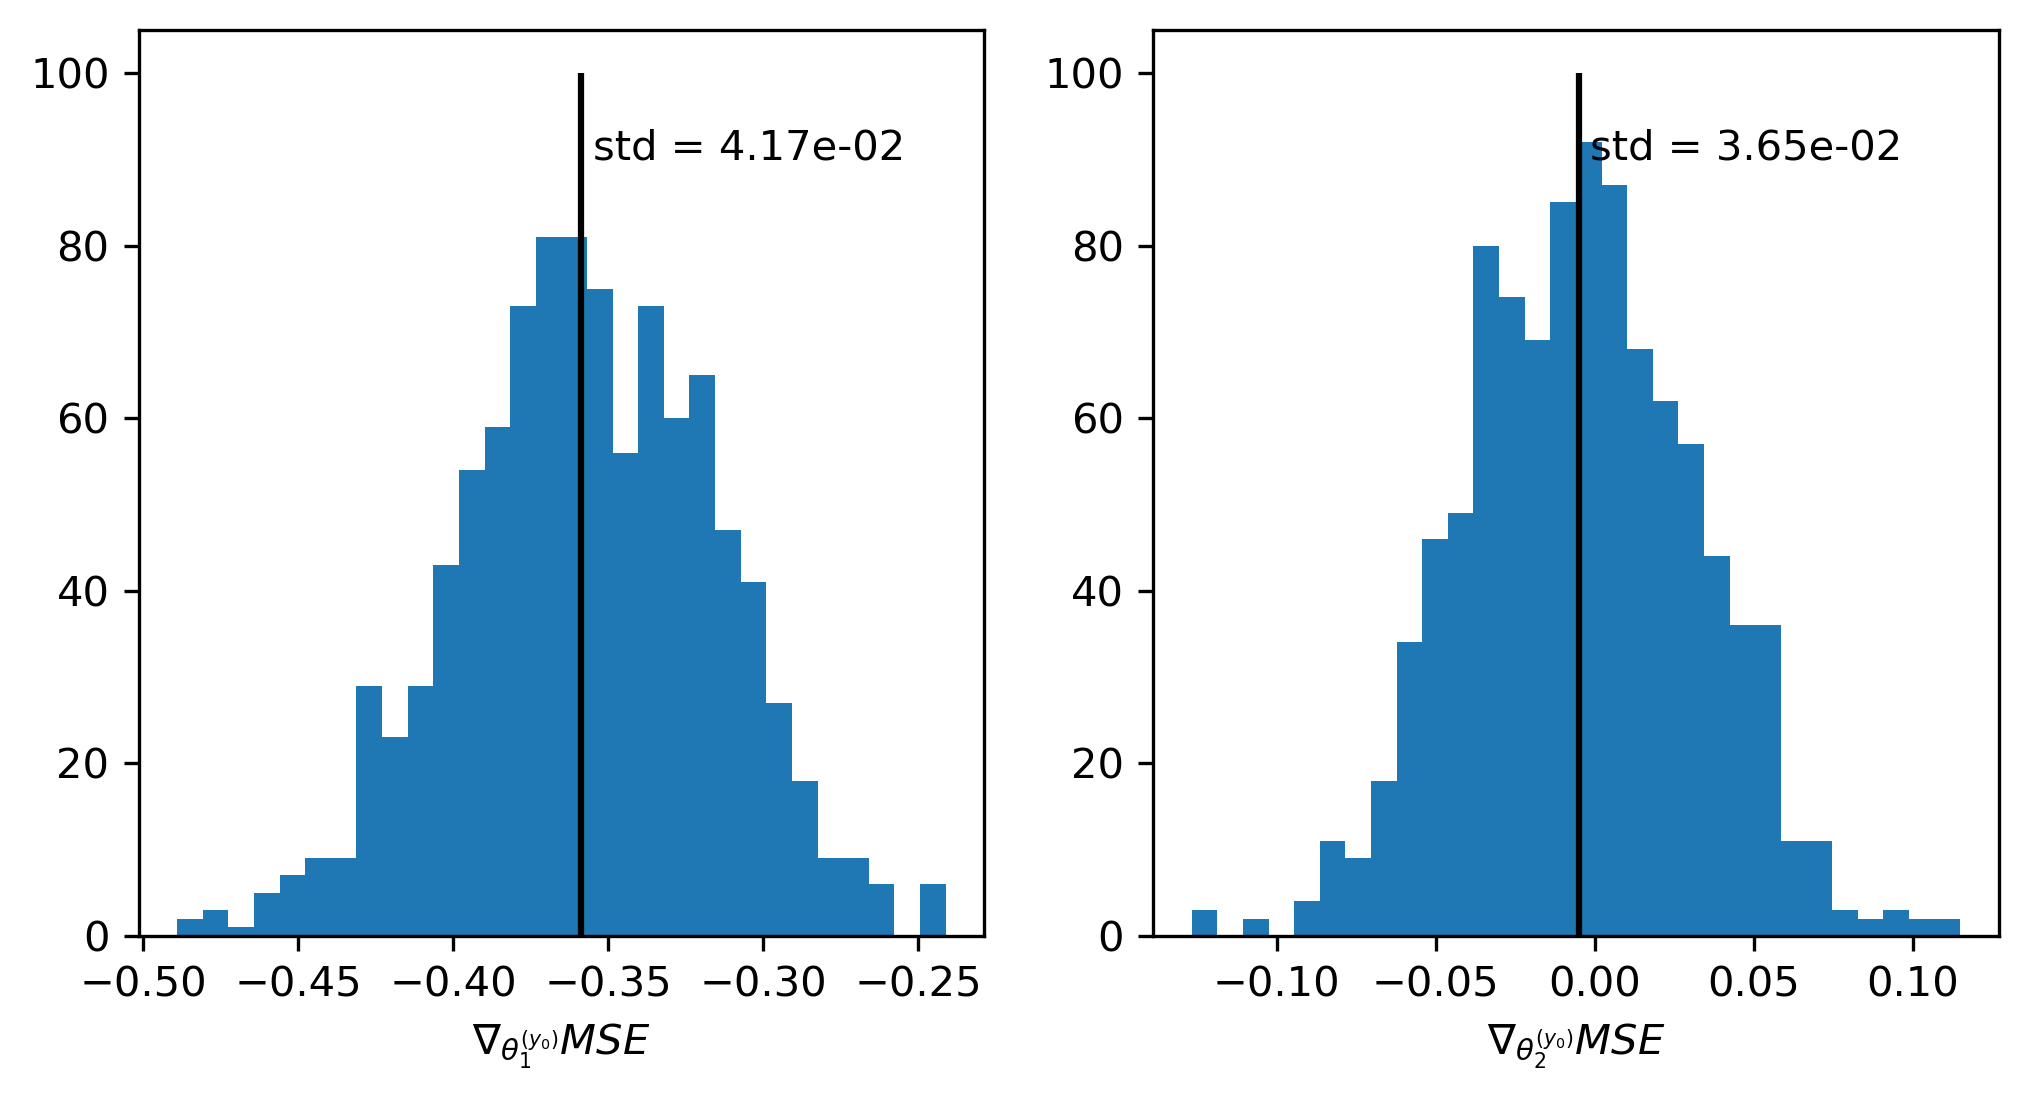

In [84]:
f = plt.figure(figsize=(8,4), dpi=300)

_ = plt.subplot(1,2,1)
_ = plt.hist(theta_1y0_grads, bins=30)
_ = plt.text(theta_grad_trainset[1,0] + 0.1*np.std(theta_1y0_grads), 90,
             'std = %.2e' % np.std(theta_1y0_grads))
_ = plt.vlines(theta_grad_trainset[1,0], 0, 100, 'black')
_ = plt.xlabel('$\\nabla_{\\theta_{1}^{(y_0)}}MSE$')

_ = plt.subplot(1,2,2)
_ = plt.hist(theta_2y0_grads, bins=30)
_ = plt.text(theta_grad_trainset[2,0] + 0.1*np.std(theta_2y0_grads), 90,
             'std = %.2e' % np.std(theta_2y0_grads))
_ = plt.vlines(theta_grad_trainset[2,0], 0, 100, 'black')
_ = plt.xlabel('$\\nabla_{\\theta_{2}^{(y_0)}}MSE$')

In [85]:
sample_sizes = (Xtrain.shape[0]/np.power(2, np.arange(0, 13))).astype(np.int)
sample_sizes

array([10000,  5000,  2500,  1250,   625,   312,   156,    78,    39,
          19,     9,     4,     2])

In [86]:
theta_1y0_grads_std = []
theta_2y0_grads_std = []
for sample_size_for_grad_estimation in tqdm(sample_sizes):
    theta_1y0_grads = []
    theta_2y0_grads = []

    for i in range(1000):
        subset_indices = np.random.permutation(Xtrain.shape[0])[:sample_size_for_grad_estimation]
        subset_X = Xtrain[subset_indices]
        subset_y = ytrain[subset_indices]
        grad_curr = loss_grad(subset_X, subset_y, theta0)
        theta_1y0_grads.append(grad_curr[1,0])
        theta_2y0_grads.append(grad_curr[2,0])
    theta_1y0_grads_std.append(np.std(theta_1y0_grads))
    theta_2y0_grads_std.append(np.std(theta_2y0_grads))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


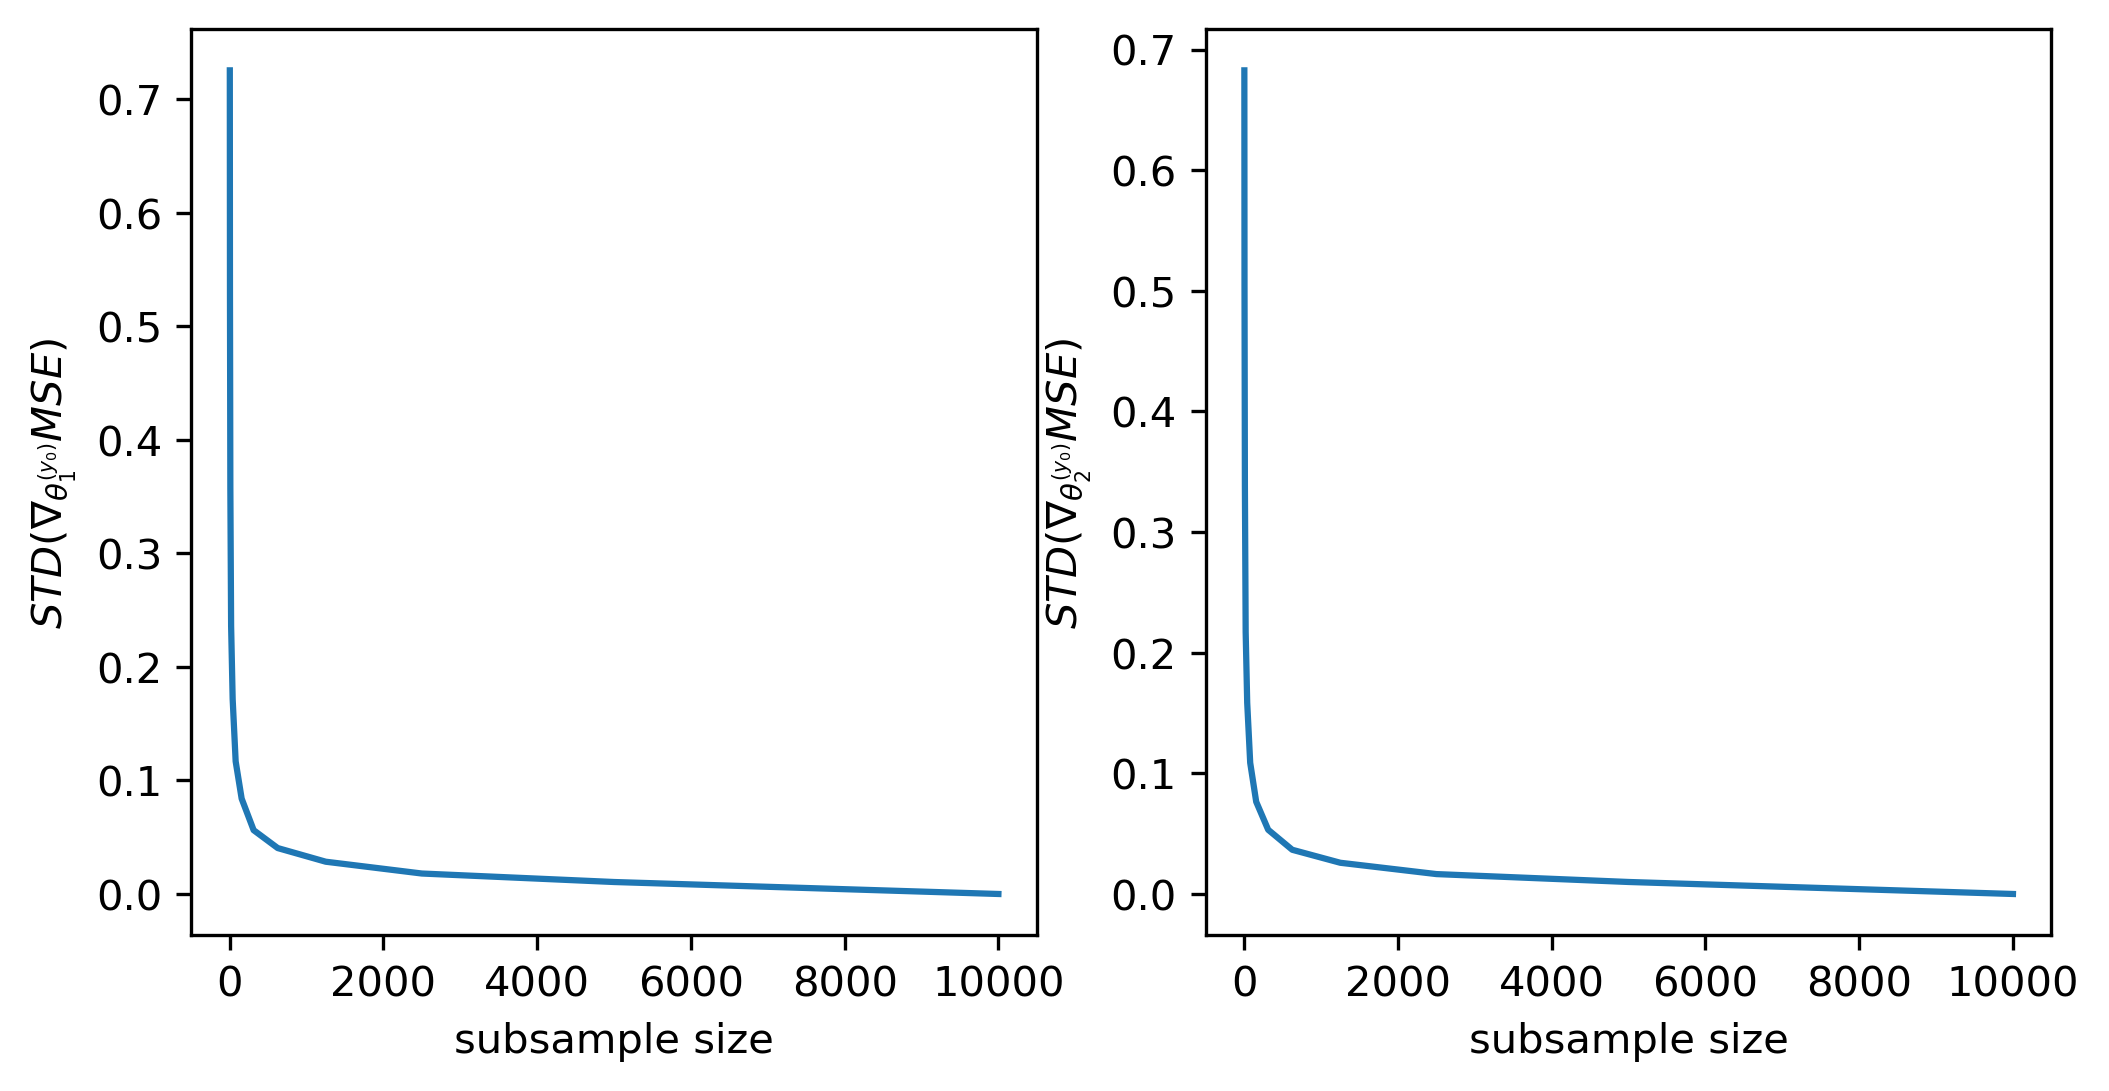

In [87]:
f = plt.figure(figsize=(8,4), dpi=300)

_ = plt.subplot(1,2,1)
_ = plt.plot(sample_sizes, theta_1y0_grads_std)
# _ = plt.vlines(theta_grad_trainset[1,0], 0, 100)
_ = plt.xlabel('subsample size')
_ = plt.ylabel('$STD(\\nabla_{\\theta_{1}^{(y_0)}}MSE)$')

_ = plt.subplot(1,2,2)
_ = plt.plot(sample_sizes, theta_2y0_grads_std)
# _ = plt.vlines(theta_grad_trainset[2,0], 0, 100)
_ = plt.xlabel('subsample size')
_ = plt.ylabel('$STD(\\nabla_{\\theta_{2}^{(y_0)}}MSE)$')

То есть, для ускорения вычислений можно оценивать градиент по части выборки!

Новый гиперпараметр решения - размер части выборки (batch size), по которой оценивается градиент на каждой итерации градиентного спуска.

Метод стохастического градиентного спуска (Stochastic gradient descent, SGD): $batch\_size=1$

### Как это работает:

In [88]:
eta = 0.05
eps = 0.0000001
batch_size = 50

In [89]:
theta_history = []
loss_history = []
grad_history = []

theta_t = theta0*5
subset_indices = np.random.permutation(Xtrain.shape[0])[:batch_size]
subset_X = Xtrain[subset_indices]
subset_y = ytrain[subset_indices]
loss_t = loss(subset_X, subset_y, theta_t)

it = 0

while True:
    it += 1    
    
    subset_indices = np.random.permutation(Xtrain.shape[0])[:batch_size]
    subset_X = Xtrain[subset_indices]
    subset_y = ytrain[subset_indices]
    
    grad_t = loss_grad(subset_X, subset_y, theta_t)
    theta_t_plus_1 = theta_t - eta*grad_t
    loss_t_plus_1 = loss(subset_X, subset_y, theta_t_plus_1)
    
    C = np.abs(loss_t_plus_1 - loss_t) < eps
    
    theta_history.append(theta_t)
    loss_history.append(loss_t)
    grad_history.append(grad_t)
    
    loss_t = loss_t_plus_1
    theta_t = theta_t_plus_1
    
    if C & (it > 1):
        break
    
    if it > 1000:
        break

In [90]:
len(loss_history)

1001

Отрисуем траекторию в пространстве параметров $\theta_{1}^{(y_0)}$, $\theta_{2}^{(y_0)}$

Text(0.5, 1.0, 'optimization history')

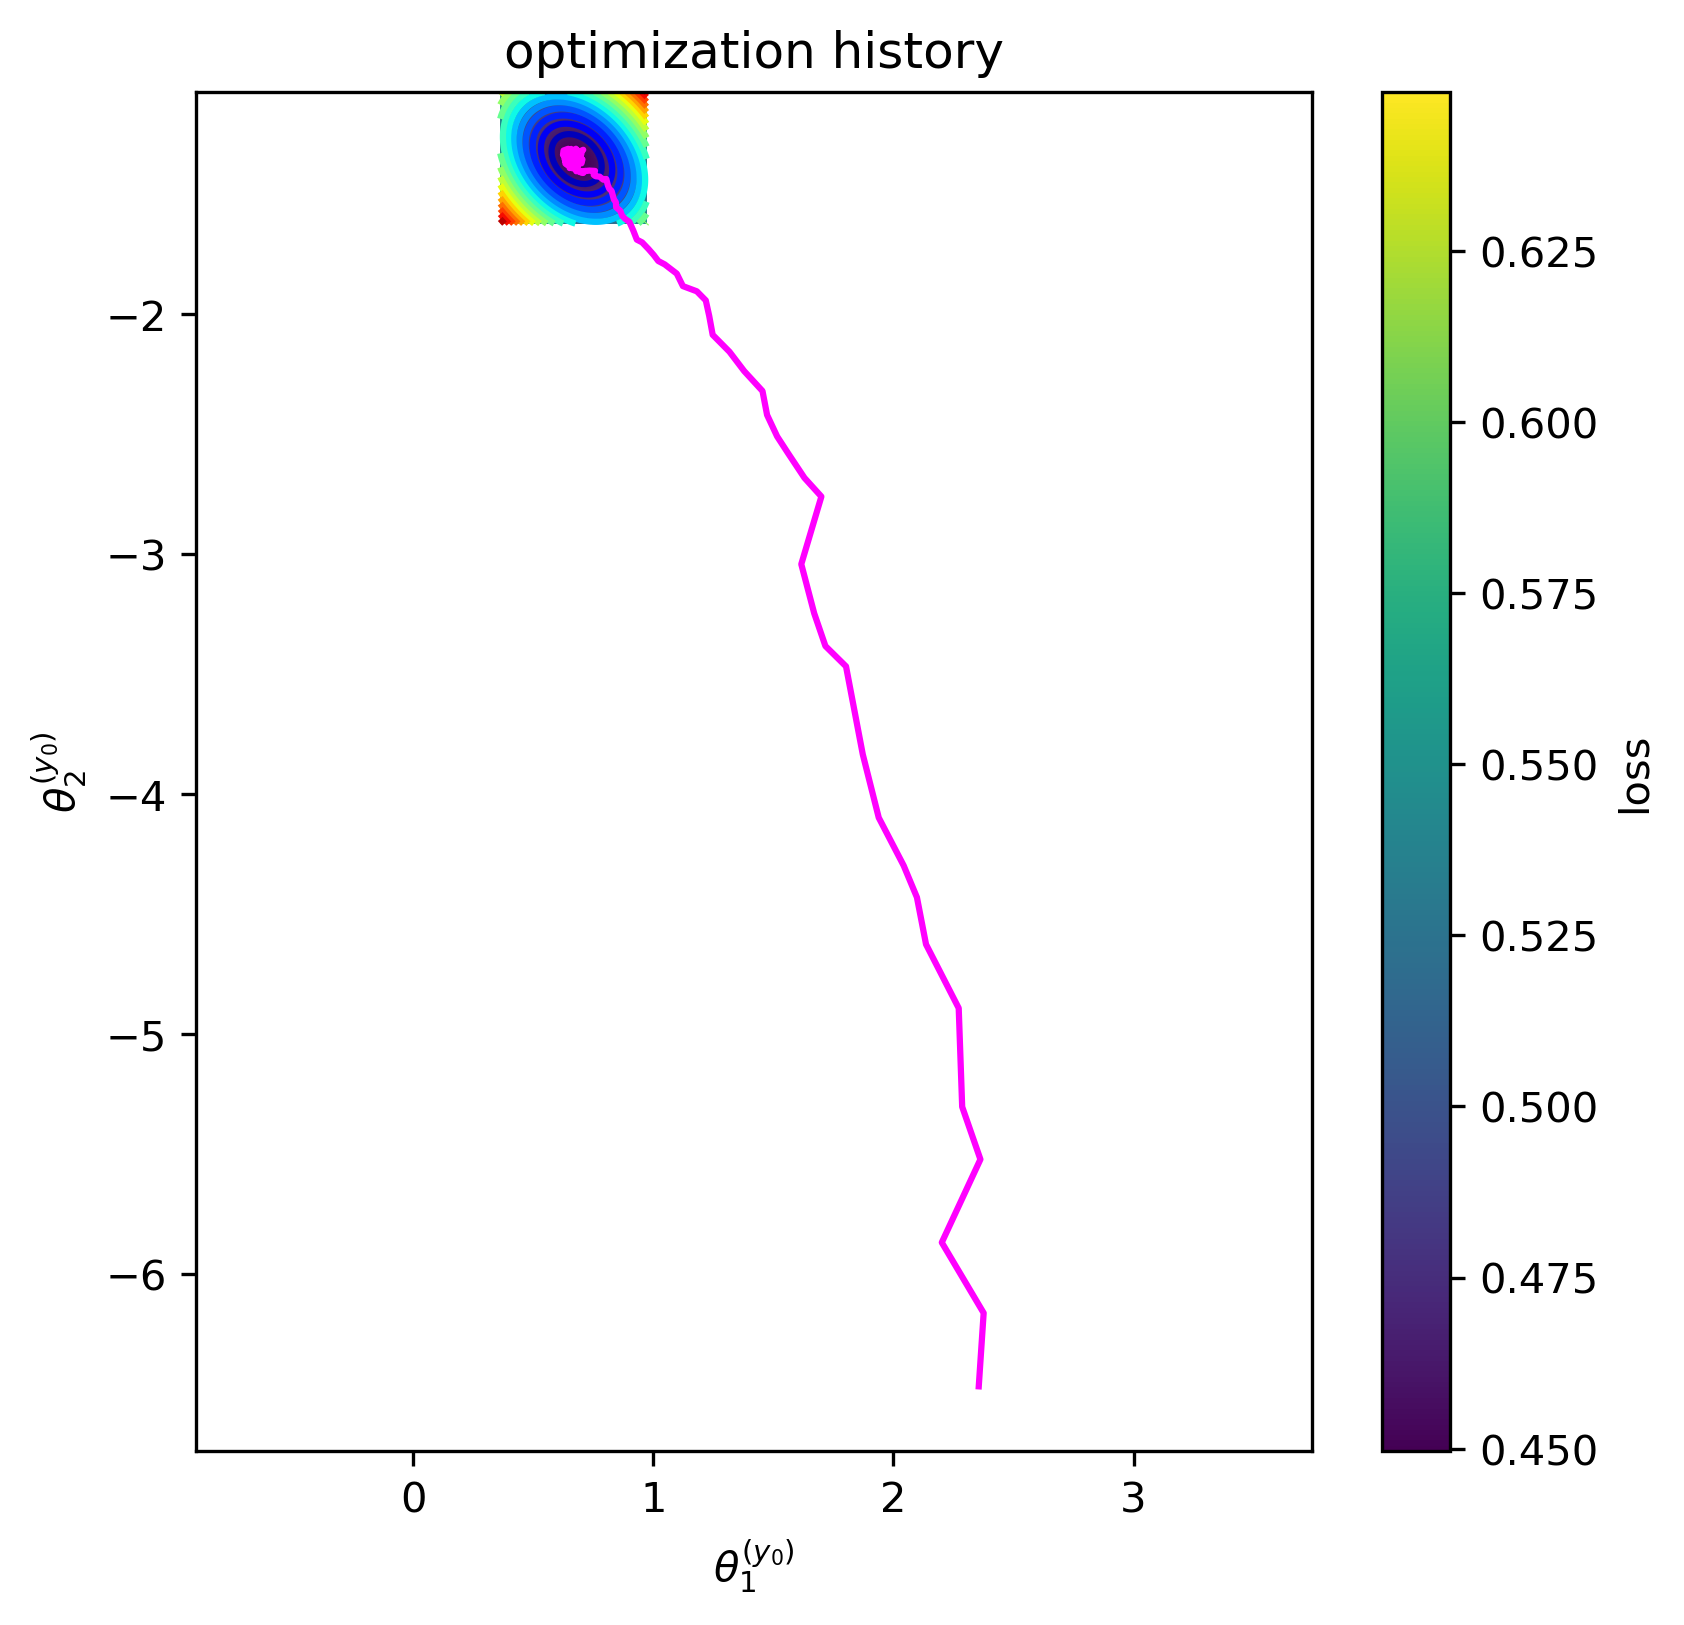

In [92]:
f = plt.figure(figsize=(6,6), dpi=300)
pcm = plt.pcolormesh(t1y0_mesh, t2y0_mesh, loss_values)
plt.contour(t1y0_mesh,
            t2y0_mesh,
            loss_values,
            levels = np.linspace(loss_values.min(),
                                 loss_values.max(), 20),
            cmap='jet')
plt.xlabel('$\\theta_{1}^{(y_0)}$')
plt.ylabel('$\\theta_{2}^{(y_0)}$')

cb = plt.colorbar(pcm)
cb.set_label('loss')

plt.plot([t[1,0] for t in theta_history], 
         [t[2,0] for t in theta_history], color='magenta')

_ = plt.axis('equal')
plt.title('optimization history')

Для контроля убедимся, что функция ошибки действительно убывает в процессе оптимизации

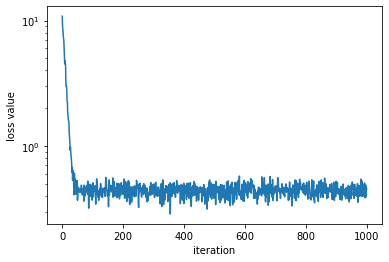

In [93]:
plt.plot(np.arange(len(loss_history)), np.array(loss_history))
plt.xlabel('iteration')
_ = plt.ylabel('loss value')
_ = plt.yscale('log')

## Вопросы на обсуждение

- Почему не останавливается по условию останова (снижение скорости приращения функции ошибки)?
- Почему путь к минимуму такой ломаный?
- Что можно сказать про историю значения функции потерь?
- Найден ли минимум?
- Если мы знаем, что минимумов много - что может произойти? В какой из минимумов приведет стохастический градиентный спуск? Всегда в один и тот же?

### "Best practices"

- Прописывать отдельно генератор данных для процедуры оценки функции ошибки и ее градиента по параметрам модели
- "ЭПОХА" - один проход генератора данных по всей обучающей выборке
- Генератор данных (чаще всего) не повторяет объекты выборки в пределах эпохи
- Качество модели (функция ошибки, другие меры качества) в процессе обучения оценивается на отложенной **валидационной выборке** в конце эпохи (ОТЛИЧАЕТСЯ от тестовой!)


### More to come
+ множество эвристических подходов улучшения сходимости SGD
+ множество более совершенных алгоритмов градиентной оптимизации с улучшенной (ускоренной) сходиомстью, сниженной дисперсией градиентов